In [1]:
import pandas as pd
import numpy as np
import random

import statsmodels.api as sm
from tqdm import tqdm
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM
from linearmodels import PanelOLS

import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.datasets import card

In [2]:
sns.set(rc={'figure.figsize':(15,12)})
sns.set_style("white")

In [3]:
# Load data
data = pd.read_csv('../data/trade-polity.csv', index_col=0)
data

,year,iso_o,iso_d,contig,comlang_off,distw,pop_o,gdp_o,gdpcap_o,iso2_o,...,gsp_rec,flow,validmirror,family,country_o,country_d,tradelink,polity_o,polity_d,polity_dist
0,1990,ARG,AGO,0,0,7977.915823,32.580860,141352.3800,4338.51000,AR,...,0,24.747800,1,NaN,Argentina,Angola,ARG-AGO,7.0,-7.0,14.0
1,1990,AUS,AGO,0,0,12954.905818,17.065100,319264.7000,18708.63300,AU,...,1,1.296240,1,NaN,Australia,Angola,AUS-AGO,10.0,-7.0,17.0
2,1990,AUT,AGO,0,0,6432.058253,7.710882,164984.0300,21396.26000,AT,...,1,2.999282,1,NaN,Austria,Angola,AUT-AGO,10.0,-7.0,17.0
3,1990,BDI,AGO,0,0,1905.419703,5.670250,1132.1012,199.65631,BI,...,0,0.000000,1,NaN,Burundi,Angola,BDI-AGO,-6.0,-7.0,1.0
4,1990,BEL,AGO,0,0,6817.662686,9.967400,202690.9700,20335.39000,BE,...,1,76.786900,1,NaN,Belgium,Angola,BEL-AGO,10.0,-7.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334437,2002,TWN,LUX,0,0,9609.759792,22.400000,294803.0000,13160.84900,TW,...,0,637.017600,0,NaN,Taiwan,Luxembourg,TWN-LUX,9.0,10.0,1.0
334438,2003,TWN,LUX,0,0,9609.759792,22.490000,299785.0000,13329.70200,TW,...,0,775.699000,0,NaN,Taiwan,Luxembourg,TWN-LUX,9.0,10.0,1.0
334439,2004,TWN,LUX,0,0,9609.759792,22.580000,322179.0000,14268.33500,TW,...,0,485.395600,0,NaN,Taiwan,Luxembourg,TWN-LUX,10.0,10.0,0.0
334440,2005,TWN,LUX,0,0,9609.759792,22.650000,345862.0000,15269.84600,TW,...,0,248.613600,0,NaN,Taiwan,Luxembourg,TWN-LUX,10.0,10.0,0.0


In [4]:
# Create gdp_dist column
data['gdp_dist'] = abs(data['gdp_o'] - data['gdp_d'])

# Do political differences between countries affect their trade flows?
---

## 1. Introduction
- Let's test whether political differences (as measured by Polity scores) affect bilateral tradeflows between countries from 1960-2006.
- Unit of interest is the annual trade relationship between two countries (e.g. NZL-AUS).
- I will first estimate the gravity model of trade and a modified gravity model by including political difference as a explanatory variable.
- I will then look at **three different identification strategies to estimate the effect of political differences on trade flows**:
    - *Fixed Effects*
    - *Arellano-Bond Instrumental Variables*
    - *Anderson-Hsiao Instrumental Variables*
- Physical distance and WTO membership between countries are included controls.

## 2. Summary Statistics
---

In [5]:
# Filter tradelinks with highest average trade volume over time

links = data.groupby('tradelink')['flow'].agg('mean').nlargest(n=15).index
largest_tradelinks = data[data['tradelink'].isin(links)]

### 2.1 Trade Flows between 1990-2006 for Top 15 Tradelinks with Highest Trade Flows

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Trade Flow (current US$ million)')]

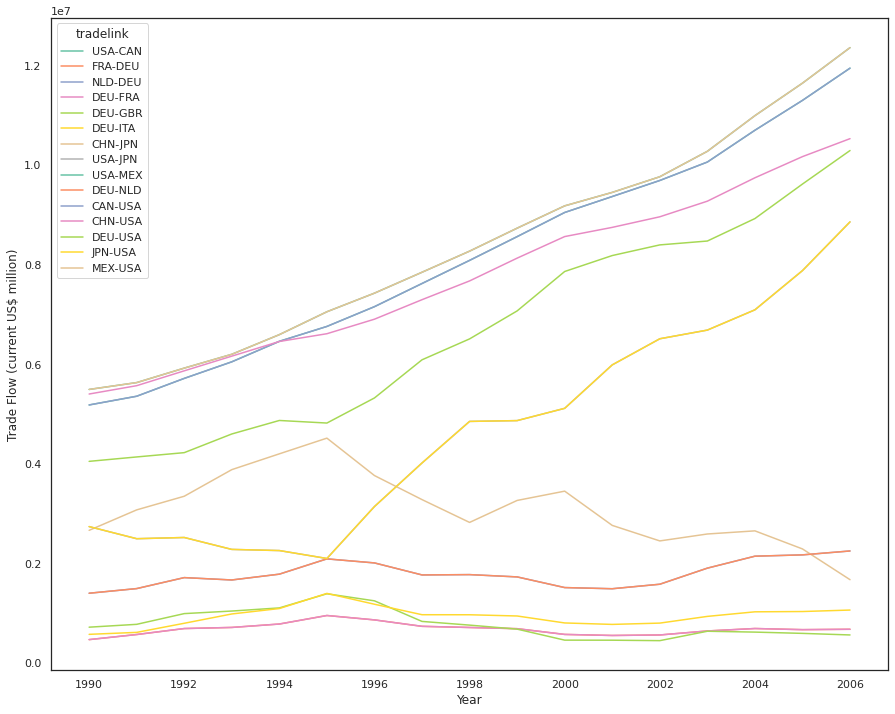

In [6]:
# Tradeflows across top 10 tradelinks with highest average total trade value over time

ax = sns.lineplot(x='year',y='gdp_dist', hue='tradelink', data=largest_tradelinks.query('year >= 1990'), palette='Set2')
ax.set(xlabel='Year', ylabel='Trade Flow (current US$ million)')

### 2.2 Jointplot of Polity Distance and Trade Flows (current USD million) for Top 15 Tradelinks

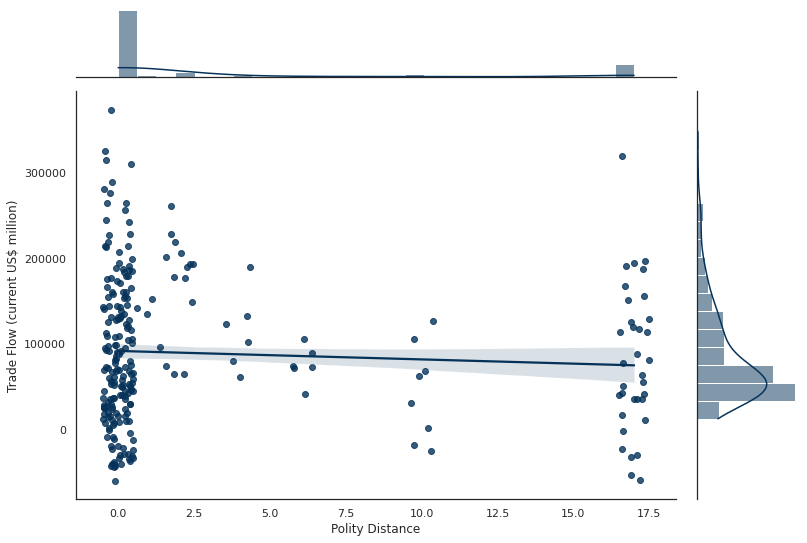

In [7]:
# Joint plot of polity distance and tradeflow

grid = sns.jointplot(x='polity_dist', y='flow', kind='reg', color='#053259', x_jitter=0.5, y_jitter=100000, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Polity Distance', ylabel='Trade Flow (current US$ million)')

### 2.3 Jointplot of Distance and Trade Flows (current USD million) for Top 15 Tradelinks

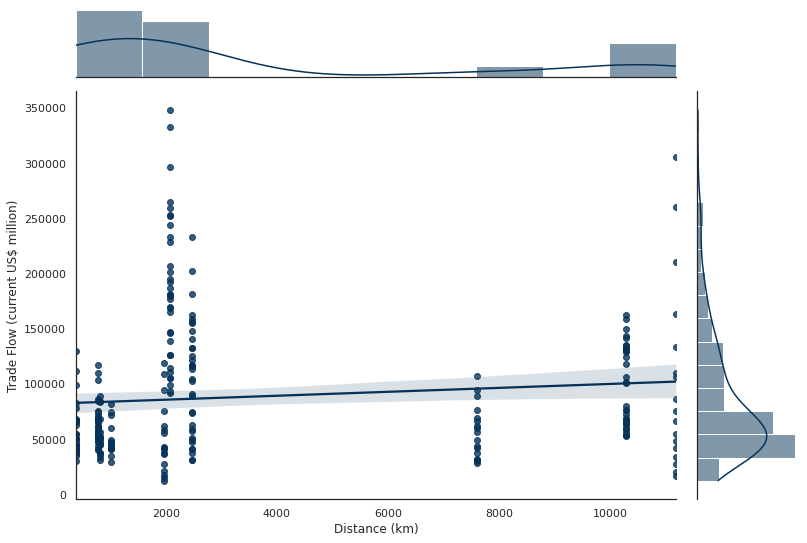

In [8]:
# Relationship between distance and flow

grid = sns.jointplot(x='distw',y='flow', kind='reg',color='#053259', data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Distance (km)', ylabel='Trade Flow (current US$ million)')

### 2.4 Change in Polity Distance over Time

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Polity')]

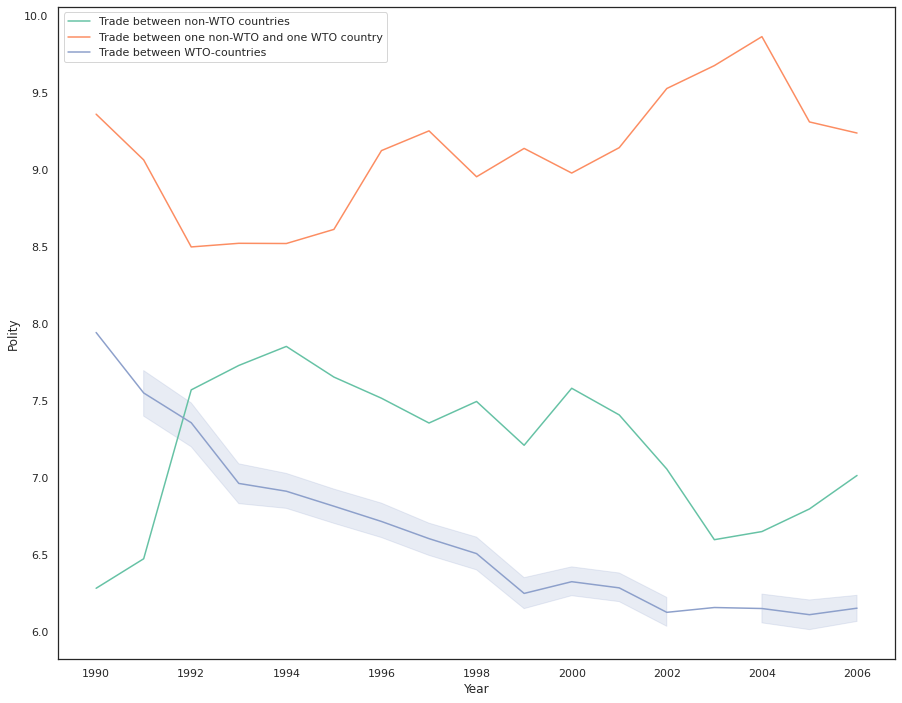

In [9]:
# Change in polity distance over time

data['wto'] = data['gatt_o'] + data['gatt_d']
ax = sns.lineplot(x='year', y='polity_dist', hue='wto', palette='Set2', data=data)
ax.legend(['Trade between non-WTO countries', 'Trade between one non-WTO and one WTO country', 'Trade between WTO-countries'])
ax.set(xlabel='Year', ylabel='Polity')

### 2.5 Number of WTO / non-WTO tradelinks over time

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Number of Tradelinks')]

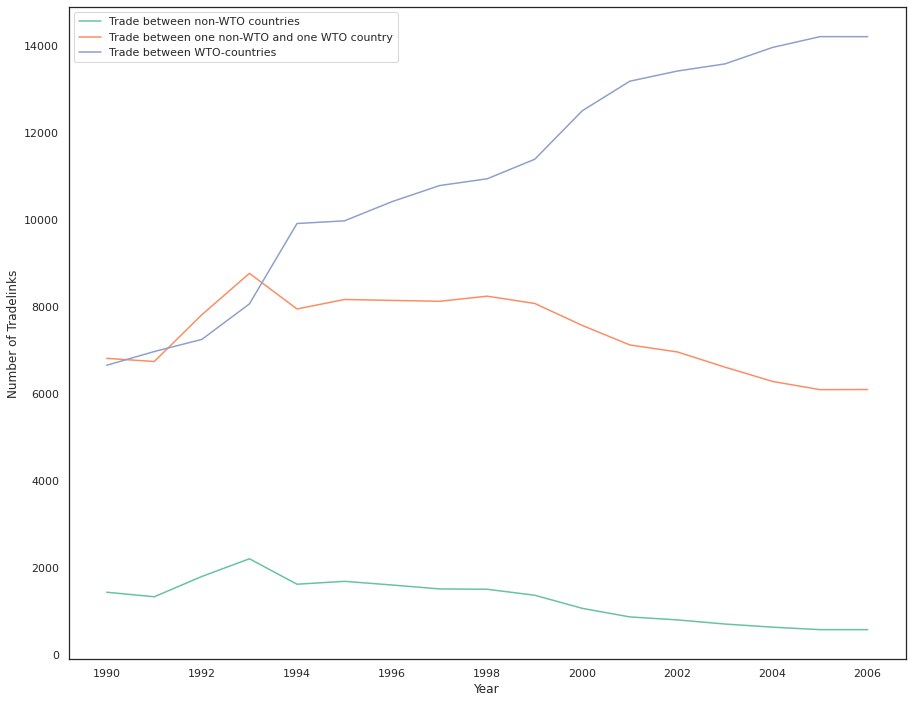

In [10]:
wto_counts = data.groupby('year')['wto'].value_counts()
wto_counts.name = 'wto_counts'
ax = sns.lineplot(x='year',y='wto_counts', hue='wto', data=wto_counts.reset_index(), palette='Set2')
ax.legend(['Trade between non-WTO countries', 'Trade between one non-WTO and one WTO country', 'Trade between WTO-countries'])
ax.set(xlabel='Year', ylabel='Number of Tradelinks')

### 2.6 Jointplot of Polity Distance and Trade Flows (current USD millions) for Top 15 WTO Tradelinks

In [11]:
links = data.query('wto == 2').groupby('tradelink')['flow'].agg('mean').nlargest(n=15).index
largest_tradelinks = data[data['tradelink'].isin(links)]

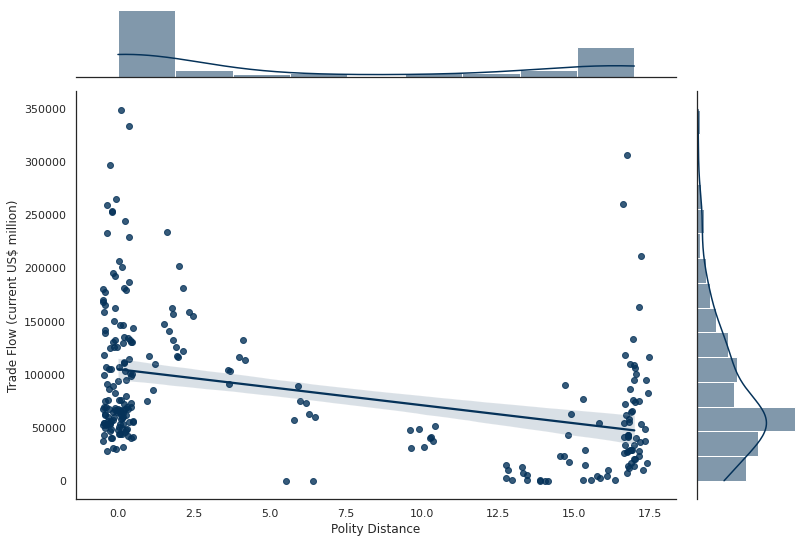

In [12]:
grid = sns.jointplot(x='polity_dist', y='flow', kind='reg', color='#053259', x_jitter=0.5, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Polity Distance', ylabel='Trade Flow (current US$ million)')

### 2.7 Jointplot of Polity Distance and Trade Flows (current USD millions) for Top 15 non-WTO Tradelinks

In [13]:
links = data.query('wto == 0').groupby('tradelink')['flow'].agg('mean').nlargest(n=15).index
largest_tradelinks = data[data['tradelink'].isin(links)]

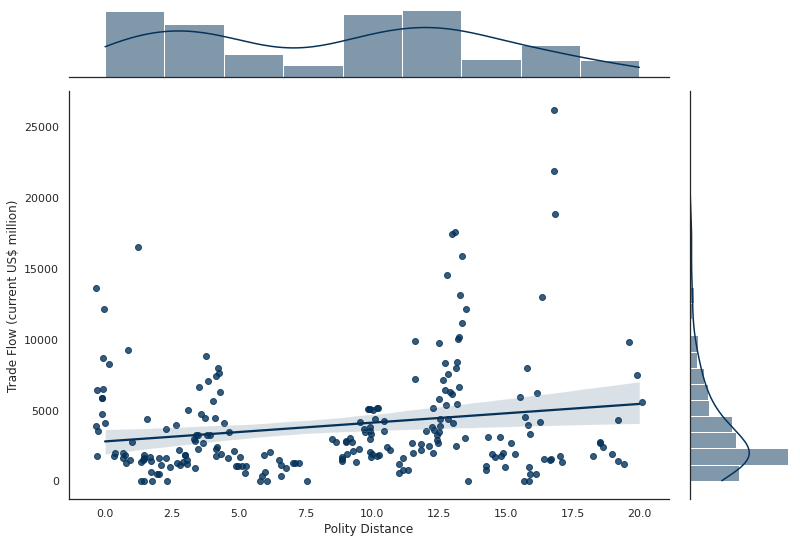

In [14]:
grid = sns.jointplot(x='polity_dist', y='flow', kind='reg', color='#053259', x_jitter=0.5, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Polity Distance', ylabel='Trade Flow (current US$ million)')

### 2.8 Jointplot of Polity Distance and Trade Flows (current USD millions) for Top 15 WTO / non-WTO Tradelinks

In [15]:
links = data.query('wto == 1').groupby('tradelink')['flow'].agg('mean').nlargest(n=15).index
largest_tradelinks = data[data['tradelink'].isin(links)]

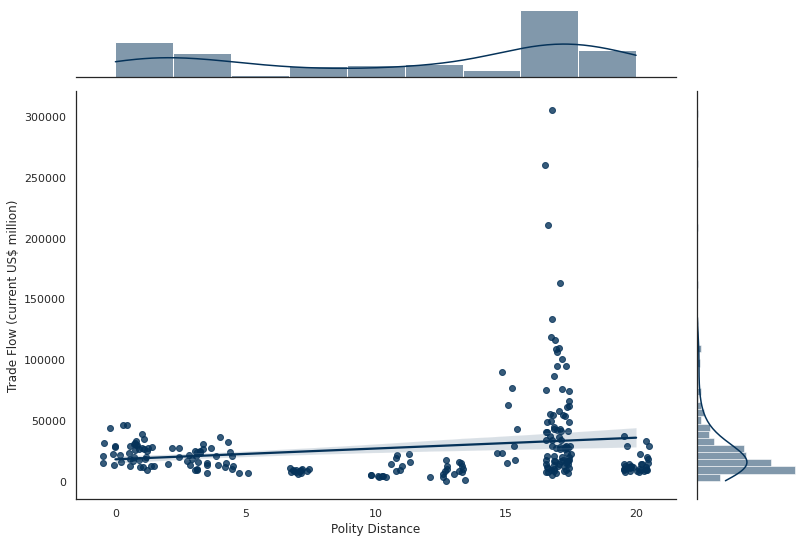

In [16]:
grid = sns.jointplot(x='polity_dist', y='flow', kind='reg', color='#053259', x_jitter=0.5, data=largest_tradelinks)
grid.fig.set_figwidth(12)
grid.fig.set_figheight(8)
grid.set_axis_labels(xlabel='Polity Distance', ylabel='Trade Flow (current US$ million)')

## 3. Results
---

In [17]:
# Set entity and time indexes
polity_data = data.set_index(['tradelink', 'year']).dropna(subset=['gdp_dist', 'polity_dist'])

# Include a year column
polity_data['year'] = polity_data.index.get_level_values('year').astype('str')

# Include a tradelink column
polity_data['tradelink'] = polity_data.index.get_level_values('tradelink').astype('str')

In [18]:
# Write function that returns original dataframe with additional lags for a specified col
# Patsy in Python does not have a lag operator to use in formulas

def get_lags(data, col, lag, level=0):
    for i in range(lag):
        data[f'{col}_{i+1}'] = data.groupby(level=level)[col].shift(i+1)
    return data

In [19]:
# Create 3 lags of gdp_dist
n_gdp_lags = 3
get_lags(polity_data, 'gdp_dist', n_gdp_lags)
 
# Create 10 lags of polity_dist
n_lags=10
get_lags(polity_data, 'polity_dist', n_lags)

# Set gdp_lags patsy formula
gdp_lags = '+'.join([f'gdp_dist_{i}' for i in range(1, n_gdp_lags+1)])

### 3.1 Fixed Effects
---

In [20]:
# Two-way fixed effects
# Note: we removed the distw covariate because it is captured in EntityEffects

formula_fe = f'flow ~ polity_dist + EntityEffects + TimeEffects'
mod_fe = PanelOLS.from_formula(formula_fe, data=polity_data)
res_fe = mod_fe.fit(cov_type="clustered", cluster_entity=True)
res_fe.summary

/home/topher-lo/anaconda3/envs/trade-polity/lib/python3.8/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Dep. Variable:,flow,R-squared:,2.759e-05
Estimator:,PanelOLS,R-squared (Between):,0.0006
No. Observations:,304700,R-squared (Within):,-0.0001
Date:,"Thu, Nov 26 2020",R-squared (Overall):,0.0005
Time:,02:58:26,Log-likelihood,-2.632e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,7.8285
Entities:,21419,P-value,0.0051
Avg Obs:,14.226,Distribution:,"F(1,283701)"
Min Obs:,0.0000,,
Max Obs:,18.000,F-statistic (robust):,2.6767


### 3.2 Anderson-Hsiao
---

In [21]:
# Anderson-Hsiao
# Following Rachel Meager's code, let's use 2-step efficient GMM to fit the A.H. model

formula_ah = f'flow ~ {gdp_lags} + [polity_dist ~ polity_dist_1] + distw + wto'
mod_ah = IVGMM.from_formula(formula_ah, data=polity_data)
res_ah = mod_ah.fit()
res_ah.summary

/home/topher-lo/anaconda3/envs/trade-polity/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/home/topher-lo/anaconda3/envs/trade-polity/lib/python3.8/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                   flow   R-squared:                      0.0672
Estimator:                     IV-GMM   Adj. R-squared:                 0.0672
No. Observations:              242626   F-statistic:                    4008.1
Date:                Thu, Nov 26 2020   P-value (F-stat)                0.0000
Time:                        02:58:35   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
gdp_dist_1      0.0009     0.0002     4.7918     0.0000      0.0005      0.0013
gdp_dist_2     -0.0002     0.0003    -0.7337     0.4631     -0.0007      0.0003
gdp_dist_3  -2.508e-05     0.0002    -0.1257     0.9000     -0.0004      0.0004
distw          -0.0658     0.0024    -27.175     0.0000     -0.0706     -0.0611
wto             437.50     12.194     35.879     0.0000      413.60      461.40
polity_dist    -23.651     1.2798    -18.480     0.0000     -26.159     -21.142
===============================================================================

Endogenous: polity_dist
Instruments: polity_dist_1
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

### 3.3 Arellano-Bond
---

In [22]:
# Arellano-Bond
# Following Rachel Meager's code, let's use 2-step efficient GMM to fit the A.B. model
arellano_results = []
for i in tqdm(range(2, n_lags + 1)):
    polity_lags = '+'.join([f'polity_dist_{j}' for j in range(1, i+1)])
    formula_ab = f'flow ~ {gdp_lags} + [polity_dist ~ {polity_lags}] + distw + wto'
    mod_ab = IVGMM.from_formula(formula_ab, data=polity_data)
    res_ab = mod_ab.fit()
    arellano_results.append(res_ab)

100%|██████████| 9/9 [01:15<00:00,  8.42s/it]


In [23]:
# Chart results
# 95% confidence intervals
num_lags = [i for i in range(2, n_lags + 1)]
conf_intervals = []

for i in range(len(arellano_results)):

    conf_int = arellano_results[i].conf_int()

    # Stack lower and upper columns,and reset index for use in seaborn API
    conf_int = conf_int.stack()
    conf_int.name = "estimate"
    conf_int = pd.DataFrame(conf_int)
    conf_int = conf_int.reset_index().rename(columns={'level_0':'regressor', 'level_1':'interval'})

    # Only keep polity_dist
    conf_int = conf_int.query('regressor == "polity_dist"')
    lag = num_lags[i]
    conf_int = conf_int.replace('polity_dist' , f'polity_dist_{lag}')
    conf_intervals.append(conf_int.set_index('regressor'))
    
conf_intervals = pd.concat(conf_intervals)

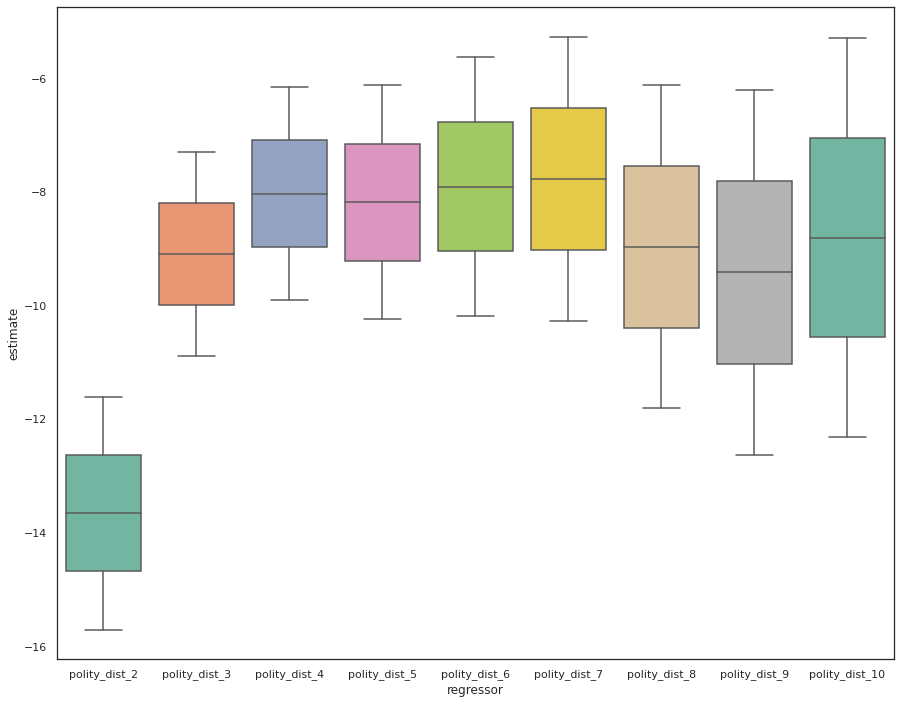

In [24]:
# Boxplot
ax = sns.boxplot(x='regressor', y='estimate', data=conf_intervals.reset_index(), palette='Set2')